# Tweet Analysis

In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sqlite3
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import matplotlib.pyplot as plt
stop_words = stopwords.words('english')
%matplotlib inline

In [2]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [3]:
conn = sqlite3.connect("../twitter_python/en_lupus.sqlite") # open the SQLite connection 
tweets = pd.read_sql_query("SELECT * FROM hashtags;", conn) # get all the tweets
tweets['created_at'] = pd.to_datetime(tweets['created_at']) # convert strings to timestamps  
orig_tweets = tweets[tweets['retweeted_status'] == 0] # only original tweets, i.e. no retweets
conn.close() # close the SQLite connection

### Get the CSVs

In [4]:
df = pd.read_csv('./train/lupus_classification.csv')
df.columns = ['username', 'time', 'content', 'NA', 'P', 'F', 'M', 'A', 'U']
# df['index'] = range(1, len(df) + 1)
# df = df.set_index('index')
df.head()

,username,time,content,NA,P,F,M,A,U
0,taeiae,00:56.0,i finished the first lupus tales fic and now i...,NaN,NaN,NaN,NaN,NaN,NaN
1,mistykj05,59:36.0,Co-ed floor same as my son. I didn't get to dr...,NaN,x,NaN,NaN,NaN,NaN
2,@DamonkWayans @keeshash,arp @dantebro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,linmp1031,56:58.0,@ajstarr10 @therealzanetta Who makes a pkgd sa...,NaN,x,x,NaN,NaN,NaN
4,_CrazyWonderful,55:04.0,I‚Äôm determined to connect with other #lupusw...,NaN,x,NaN,NaN,NaN,NaN


In [5]:
df2 = pd.read_csv('./train/november400.csv')
df2.columns = ['tweet_id', 'username', 'time', 'content', 'NA', 'P', 'F', 'M', 'A']
df2 = df2[['username', 'time', 'content', 'NA', 'P', 'F', 'M', 'A']]
df2.head()

,username,time,content,NA,P,F,M,A
0,biotweeps,53:28.0,Atlantic Wolffish (Anarhichas lupus) is also s...,x,NaN,NaN,NaN,NaN
1,ohellvis,52:12.0,"@JOHN__JUAN @RapUp bitch, no one! but I think ...",NaN,x,NaN,NaN,NaN
2,LupusCorner,52:08.0,2 goals of topical treatments for cutaneous &a...,NaN,NaN,NaN,x,NaN
3,DaIaiGoat,51:23.0,@JaguarPaw90 @tellmecarey It's not heartless. ...,NaN,x,NaN,NaN,NaN
4,JaguarPaw90,48:54.0,@tellmecarey @DaIaiGoat She almost died from l...,NaN,x,NaN,NaN,NaN


In [6]:
df = df.append(df2) # append the dataframes 

### Clean the data 

In [7]:
df = df.dropna(subset=['content'])
df = df.dropna(subset=['NA', 'P', 'F', 'M', 'A'], how='all') 
print("Tweet count:", len(df))

Tweet count: 661


In [8]:
def get_category_number(row): 
    if not pd.isnull(row['NA']): 
        return 0
    if not pd.isnull(row['P']): 
        return 1
    if not pd.isnull(row['F']): 
        return 2
    if not pd.isnull(row['M']): 
        return 3
    if not pd.isnull(row['A']): 
        return 4
    return 0

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


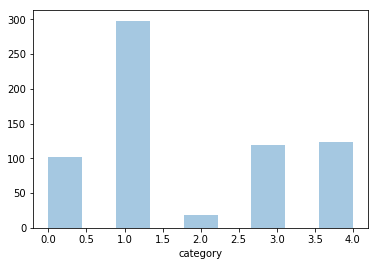

In [9]:
df['category'] = df.apply(lambda r: get_category_number(r), axis = 1)
df = df[df['category'] >= 0]
sns.distplot(df['category'], kde=False)

In [10]:
df = df[['content', 'category']]
df.head()

,content,category
1,Co-ed floor same as my son. I didn't get to dr...,1
3,@ajstarr10 @therealzanetta Who makes a pkgd sa...,1
4,I‚Äôm determined to connect with other #lupusw...,1
5,New Blog: My open letter to @selenagomez about...,1
7,@LADAOrg so happy I found this page!! #iamnot...,1


In [11]:
y = df['category'].values
xtrain, xvalid, ytrain, yvalid = train_test_split(df['content'].values, y, 
                                                  stratify=y, 
                                                  random_state=35, 
                                                  test_size=0.1, shuffle=True)

# "Classic" Categorization Algorithms

### Count Vectorization

In [12]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

### TF-IDF Vectorization

In [13]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                      strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                      stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

### Naive Bayes with Count Vectorization

In [88]:
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 2.406 


### Naive Bayes with TF-IDF 

In [89]:
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.863 


### Logistic Regression with Count Vectorization

In [90]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.737 


### Logistic Regression with TF-IDF

In [16]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.891 


# GloVe

In [17]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

embeddings_index = {}
f = open('../../glove/glove.840B.300d.txt')
count = 0

# 2 196 017

for line in f:
    count += 1
    if (count % 500000 == 0): 
        print(count)
    values = line.split()
    word = values[0]
    i = 1
    while not isfloat(values[i]):
        word = word + ' ' + values[i]
        i = i + 1
    if i > 1:
        print('Exceptional case: {0}'.format(word))
    coefs = np.asarray(values[i:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Exceptional case: . . .
Exceptional case: at name@domain.com
Exceptional case: . . . . .
Exceptional case: to name@domain.com
Exceptional case: . .
Exceptional case: . . . .
Exceptional case: email name@domain.com
Exceptional case: or name@domain.com
500000
Exceptional case: contact name@domain.com
Exceptional case: Email name@domain.com
Exceptional case: on name@domain.com
1000000
Exceptional case: At Killerseats.com
Exceptional case: by name@domain.com
Exceptional case: in mylot.com
Exceptional case: emailing name@domain.com
1500000
Exceptional case: Contact name@domain.com
Exceptional case: at name@domain.com
Exceptional case: • name@domain.com
2000000
Exceptional case: at Amazon.com
Exceptional case: is name@domain.com


In [18]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower() ## .decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [19]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in xtrain]
xvalid_glove = [sent2vec(x) for x in xvalid]

In [20]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [42]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

In [22]:
print ("xgb logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

xgb logloss: 0.827 


## Deep Learning

In [23]:
scl = StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [24]:
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [81]:
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# third layer didn't help 
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())

model.add(Dense(5))
model.add(Activation('softmax'))
# model.add(Activation('sigmoid')) # sigmoid activation worked better than softmax 

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
%%capture
hist = model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
                 epochs=18, verbose=1, 
                 validation_data=(xvalid_glove_scl, yvalid_enc))

Three Layers, sigmoid activation on last layer

In [70]:
print("Train data accuracy: ", hist.history['acc'][-1])
print("Test data accuracy: ", hist.history['val_acc'][-1])

Train data accuracy:  0.9545454539433874
Test data accuracy:  0.835820895522388


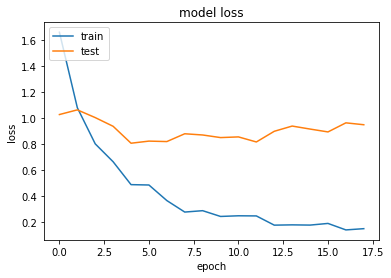

In [71]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Two layers, sigmoid activation on last layer:

In [63]:
print("Train data accuracy: ", hist.history['acc'][-1])
print("Test data accuracy: ", hist.history['val_acc'][-1])

Train data accuracy:  0.968013468214157
Test data accuracy:  0.7611940298507462


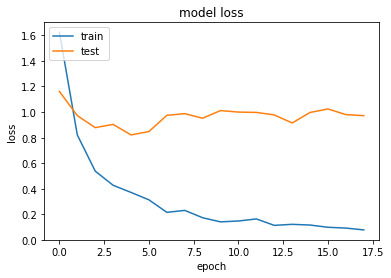

In [64]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Two layers, softmax activation on last layer:

In [74]:
print("Train data accuracy: ", hist.history['acc'][-1])
print("Test data accuracy: ", hist.history['val_acc'][-1])

Train data accuracy:  0.8956228958235847
Test data accuracy:  0.746268656716418


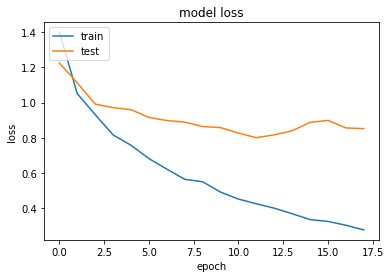

In [75]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
predictions = model.predict(x=xvalid_glove_scl)

In [84]:
print ("ANN logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

ANN logloss: 1.634 


## Classifying all Tweets

In [ ]:
ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), stop_words='english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [ ]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))